# Attribute importance ranking for synthetic data with known change points
The process change points are known. Hence, no change point detection algorithm needs to be used.

In [1]:
import pm4py
import helper
import pandas as pd

In [2]:
# data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/ROI/ROI2.5k.xes'
# data_file_path = 'data/synthetic/maardji et al 2013_xes_attributes/logs/cb/cb10k.xes'
data_file_path = 'data/synthetic/generated/new_attribute_values/2500_sudden_5_00.xes'

## Load an event log

In [3]:
# Display the data info
data_info = helper.get_data_information(data_file_path)
data_info

change_points = data_info['change_points']

In [4]:
# load the event log into pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
event_log = xes_importer.apply(data_file_path)

C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1652.38it/s]


In [5]:
from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing

In [6]:
# build the primary process drift detector
primary_feature_extractor = feature_extraction.RelationalEntropyFeatureExtractor()
primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=5)
primary_population_comparer = pop_comparison.KSTestPopComparer()
primary_threshold = 0.5
primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               threshold=primary_threshold)

In [7]:
# # build the primary process drift detector
# primary_feature_extractor = feature_extraction.RelationshipTypesCountFeatureExtractor('Relationship types count')
# primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
# primary_population_comparer = pop_comparison.HotellingsTSquaredPopComparer()
# primary_threshold = 0.5
# primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
#                                                                primary_window_generator,
#                                                                primary_population_comparer, 
#                                                                threshold=primary_threshold)

In [8]:
# # generate random window
# import itertools
# gen = primary_window_generator.get_windows(event_log)
# index = 200
# window_a, window_b = next(itertools.islice(gen, index, None))
# print(window_a.start)
# print(window_b.start)

In [9]:
# # generate features
# features_window_a = primary_feature_extractor.extract(window_a.log)
# display(features_window_a.head())
# features_window_b = primary_feature_extractor.extract(window_b.log)
# display(features_window_b.head())

In [10]:
# # perform test for features
# result = pop_comparison.HotellingsTSquaredPopComparer().compare(features_window_a, features_window_b)

In [11]:
# result

In [12]:
# build the secondary process drift detectors
secondary_window_generator = primary_window_generator
secondary_population_comparer = pop_comparison.HellingerDistanceComparer()
secondary_threshold = primary_threshold
secondary_exclude_attributes = ['concept:name']
secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer, 
                                                                         threshold=secondary_threshold,
                                                                         exclude_attributes=secondary_exclude_attributes)

In [13]:
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

In [14]:
primary_and_secondary_change_series = drift_explainer.get_primary_and_secondary_change_series(event_log)
primary_and_secondary_change_series

(155     1.000000
 160     1.000000
 165     1.000000
 170     0.999985
 175     1.000000
           ...   
 2335    1.000000
 2340    1.000000
 2345    1.000000
 2350    1.000000
 2355    1.000000
 Length: 441, dtype: float64,
 {'Attribute: relevant_attribute_5': 155     0.965071
  160     0.955077
  165     0.974931
  170     0.974931
  175     0.975056
            ...   
  2335    0.946843
  2340    0.950192
  2345    0.955788
  2350    0.951562
  2355    0.934470
  Length: 441, dtype: float64,
  'Attribute: relevant_attribute_1': 155     0.749427
  160     0.738550
  165     0.717159
  170     0.699767
  175     0.682432
            ...   
  2335    0.976032
  2340    0.968496
  2345    0.982512
  2350    0.976740
  2355    0.961069
  Length: 441, dtype: float64,
  'Attribute: irrelevant_attribute_1': 155     0.828667
  160     0.833215
  165     0.834197
  170     0.834923
  175     0.833215
            ...   
  2335    0.870191
  2340    0.905885
  2345    0.921384
  2350    0.90

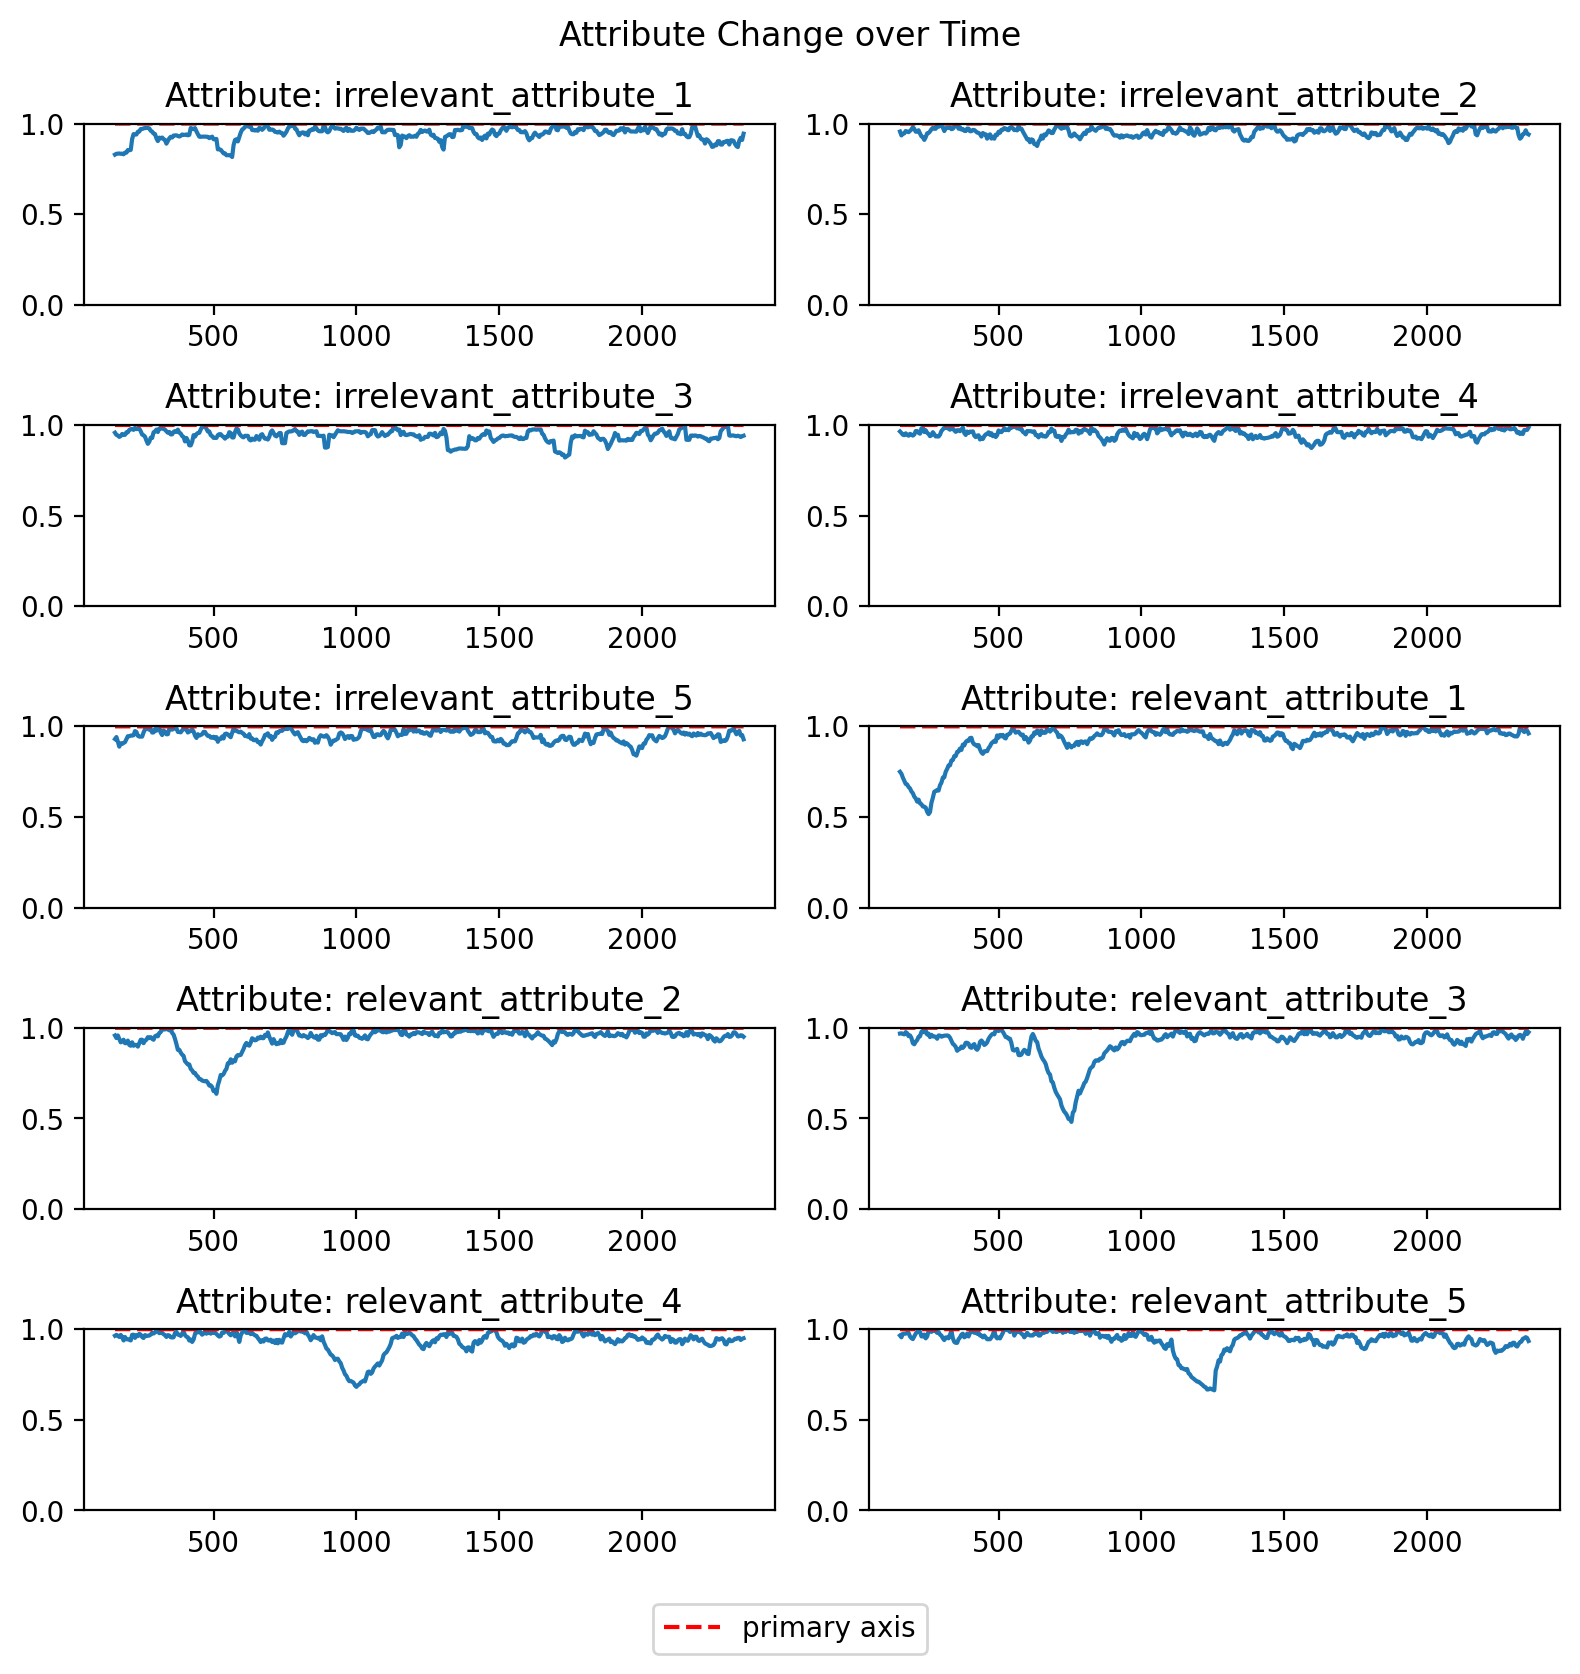

In [22]:
drift_explainer.plot_primary_and_secondary_change_series(primary_and_secondary_change_series)